# FrankenBlast Single Object Tutorial

This tutorial will walk you through how to use FrankenBlast on a single transient to: (1) associate it to its host galaxy, (2) perform global aperture photometry on the host using archival data, and (3) determine its stellar population properties through an SBI++, Prospector-based SED fit. Refer to details on the FrankenBlast infrastructure in Nugent et al. 2025.

CURRENT ISSUES:

We are currently experiencing an issue with the updated astro-prost PanSTARRS host association. To bypass this error, please edit the helpers.py file in astro-prost and comment out lines 2829-2830 (line 2829: galaxies["redshift_mean"] = np.nan, line 2830: galaxies["redshift_std"] = np.nan). This will return "0" as the redshift of the host, so please be aware of that! The other option is to not run astro-prost with PanSTARRS: to do this, you can simply delete "panstarrs" from the "catalogs" dictionary in line 278 in FrankenBlast's get_host.py.

We will update this tutorial and all FrankenBlast code once all issues have been resolved! Please send an email to Anya Nugent (anya.nugent[at]cfa.harvard.edu) if you have any questions or need to report an issue.

In [1]:
# Imports
import importlib
%load_ext autoreload
%autoreload 2
    
import os
from datetime import datetime
import pandas as pd
from scipy.stats import gamma, halfnorm, uniform
from astropy.cosmology import WMAP9 as cosmo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
from classes import Transient, Host, Filter
import csv
import shutil
import glob
import pathlib
import astropy.units as u
from urllib.error import HTTPError
from mpire import WorkerPool
import time
import numpy as np
import requests
import get_host
import pandas
from get_host_images import download_and_save_cutouts, survey_list, get_cutouts
from create_apertures import construct_aperture
import sys
from do_photometry import do_global_photometry
import os
from sedpy.observate import load_filters
from fit_host_sed import run_training_set, build_obs, build_model, fit_sbi_pp, build_model_nonparam
import prospect.io.read_results as reader
from prospect.sources import FastStepBasis
from prospect.utils.plotting import quantile
import sedpy
from postprocess_sbi import save_all as psbi_save
import  matplotlib.pyplot as plt
from fit_host_sed import fit_host, maggies_to_asinh
from prospect.plotting.utils import sample_posterior
import corner as triangle
from prospect.io.read_results import traceplot, subcorner
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import matplotlib.ticker as mticker
from mwebv_host import get_mwebv

# Transient Host Association with Pröst

We use Pröst for transient host association, which uses data from DECaLS (DR10), PanSTARRS (DR 2), and the latest GLADE+ release to find putative host galaxies.

We begin by instantiating a transient object. Fill in the name, coordinates, and redshift of the transient (if available). FrankenBlast will determine line-of-sight Galactic extinction for this object once the coodinates have been provided.

In [2]:
transient_class = Transient(
    name='2019ulo',
    coordinates = SkyCoord(ra=133.278015*u.deg, dec=-6.329666*u.deg, frame='icrs'),
    transient_redshift= 0.041,
    milkyway_dust_reddening=None,  # Initially None
    )

# Milky-Way reddening from transient coordinates
transient_class.milkyway_dust_reddening = get_mwebv(transient_class)

We then run Pröst on this transient. You have the option to save your data to a CSV file. "prost_results" is a dictionary that contains the name of the transient, the host RA, Dec, redshift, and redshift uncertainty, and the Pröst total posterior probability on the host, as well as the smallcone probability (probability that the true host is outside the search radius) and the missedcat probability (probability that the true host is not detected in the survey). We also include the catalog and data release of where the host association was made.

In [3]:
output_dir = './prostdb/' # where to save data
prost_results = get_host.run_prost(transient_class, output_dir, save=True)

/Users/anyanugent/Desktop/frankenblast-host-main/get_host.py:273: DtypeWarning: Columns (14,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  glade_catalog=pd.read_csv(f'{PROST_ROOT}/GLADE+_HyperLedaSizes_mod_withz.csv.gz'),
2025-08-20 11:38:09,130- INFO - Setting redshift uncertainty for 2019ulo to floor of 0.00205.
2025-08-20 11:38:09,131- INFO - 

Associating 2019ulo at RA, DEC = 133.278015, -6.329666 (redshift 0.041)
2025-08-20 11:38:09,132- INFO - Running with shred_cut = True...
2025-08-20 11:38:13,661- INFO - Removing panstarrs dr2 shreds.
2025-08-20 11:38:13,783- INFO - Removed 22 flagged panstarrs sources.
/opt/anaconda3/envs/frankenblast-hosts/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
2025-08-20 11:38:15,314- INFO - Association successful!
2025-08-20 11:38:15,339- INFO - 
    
Properties of best host

Take a look at the results. In particular, you may be interested in the redshift and redshift uncertainty on the host. If the redshift uncertainty is very low (z_std < 0.02), you may want to use that as the spectroscopic redshift of the host in the SED fit.

In [4]:
prost_results

{'name': '2019ulo',
 'host_ra': 133.27676432908046,
 'host_dec': -6.3308787355759275,
 'host_redshift_mean': 0.046109,
 'host_redshift_std': 0.00808,
 'host_prob': 0.9999999999937177,
 'smallcone_posterior': 2.0809183932127927e-12,
 'missedcat_posterior': 2.0809183932127927e-12,
 'best_cat': 'decals',
 'best_cat_release': 'dr9'}

We now instantiate the host object. In this case, since we know the redshift of the transient, we use the transient redshift of the host redshift. You can change this as desired.

In [5]:
# Get best host..
best_host = Host(name=transient_class.name, 
				redshift=transient_class.transient_redshift, 
                photometric_redshift = None,
                host_prob = prost_results['host_prob'],
                missedcat_prob = prost_results['missedcat_posterior'],
                smallcone_prob = prost_results['smallcone_posterior'],
                association_catalog = prost_results['best_cat'],
				milkyway_dust_reddening=transient_class.milkyway_dust_reddening,
				coordinates=SkyCoord(ra=prost_results['host_ra'] * u.deg, dec=prost_results['host_dec'] * u.deg, frame='icrs'))

transient_class.host = best_host

# Perform Host Galaxy Photometry

To do aperture photometry on the host, we first download archival images of the field in public surveys. The 'survey_frankenblast_metadata.yml' file gives us information on which surveys we wish to download data from (GALEX, DECaLS, PanSTARRS, 2MASS, and WISE). This file also includes information on zeropoints and wavelength ranges for each survey band, and is needed for the photometry. Please do not edit this file, as SBI++ also requires this for the SED fit.

In [6]:
# Make filters
survey_metadata_path = "./data/survey_frankenblast_metadata.yml"
surveys = survey_list(survey_metadata_path)
filters = Filter.all()

Now, we download all available data. All images will be put into ./cutouts/transient_class.name/. If you have already downloaded the images, you can set DOWNLOAD_CUTOUTS = False.

In [7]:
DOWNLOAD_CUTOUTS = True

if DOWNLOAD_CUTOUTS:
    download_and_save_cutouts(transient_class, filters=Filter.all())

Processing filter: 2MASS_H from survey 2MASS
Saved cutout to: ./cutouts/2019ulo/2MASS/2MASS_H.fits
Processing filter: 2MASS_J from survey 2MASS
Saved cutout to: ./cutouts/2019ulo/2MASS/2MASS_J.fits
Processing filter: 2MASS_K from survey 2MASS
Saved cutout to: ./cutouts/2019ulo/2MASS/2MASS_K.fits
Processing filter: WISE_W1 from survey WISE
Saved cutout to: ./cutouts/2019ulo/WISE/WISE_W1.fits
Processing filter: WISE_W2 from survey WISE
Saved cutout to: ./cutouts/2019ulo/WISE/WISE_W2.fits
Processing filter: WISE_W3 from survey WISE
Saved cutout to: ./cutouts/2019ulo/WISE/WISE_W3.fits
Processing filter: WISE_W4 from survey WISE
Saved cutout to: ./cutouts/2019ulo/WISE/WISE_W4.fits
Processing filter: GALEX_NUV from survey AIS
Saved cutout to: ./cutouts/2019ulo/AIS/GALEX_NUV.fits
Processing filter: GALEX_FUV from survey AIS
Saved cutout to: ./cutouts/2019ulo/AIS/GALEX_FUV.fits
Processing filter: PanSTARRS_g from survey DR1
Saved cutout to: ./cutouts/2019ulo/DR1/PanSTARRS_g.fits
Processing fil

In the next code block, we measure an elliptical aperture in each filter and perform photometry using that aperture size. We show plots of the host and the measured aperture to validate the aperture size and shape and the photometry.

DES_g
DES_r
DES_z
GALEX_NUV
GALEX_FUV
PanSTARRS_i
PanSTARRS_z
PanSTARRS_y
PanSTARRS_r
PanSTARRS_g
2MASS_J
2MASS_K
2MASS_H
WISE_W1
WISE_W4
WISE_W2
WISE_W3


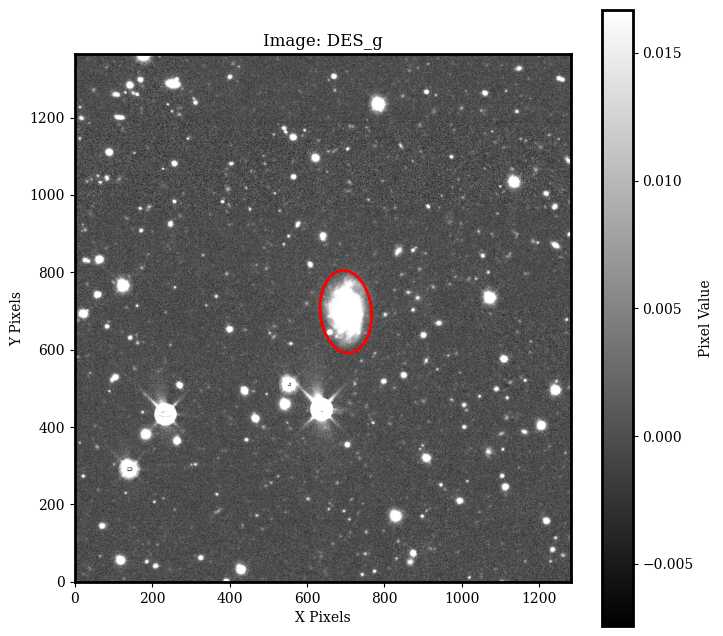

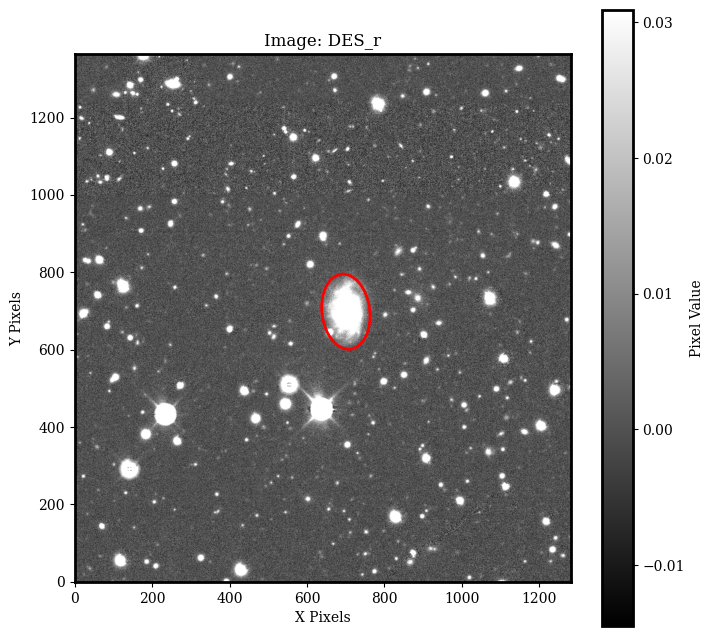

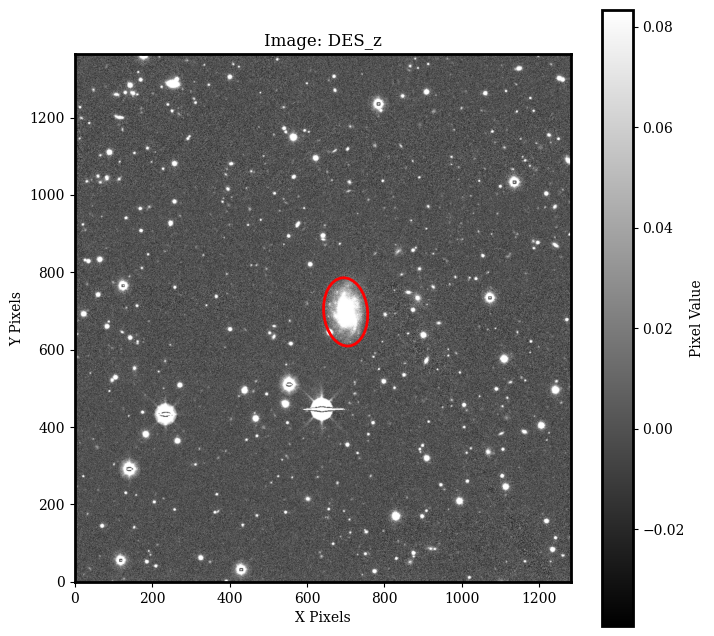

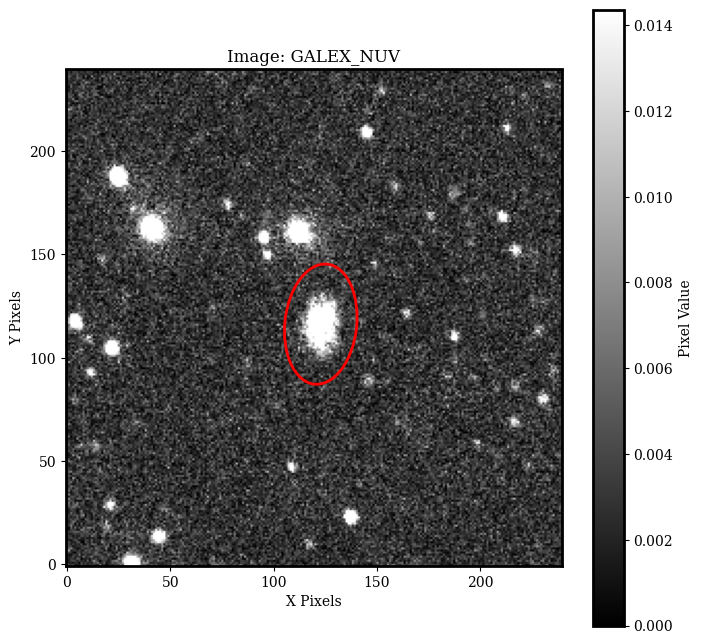

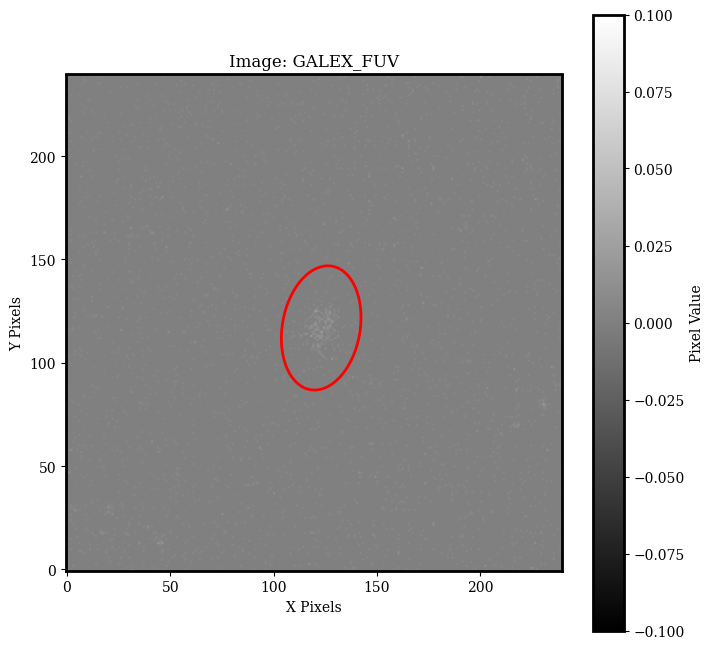

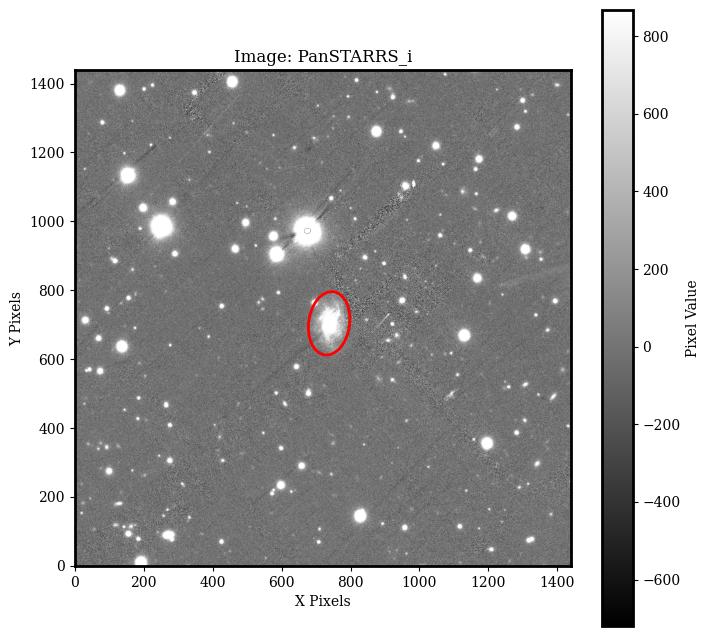

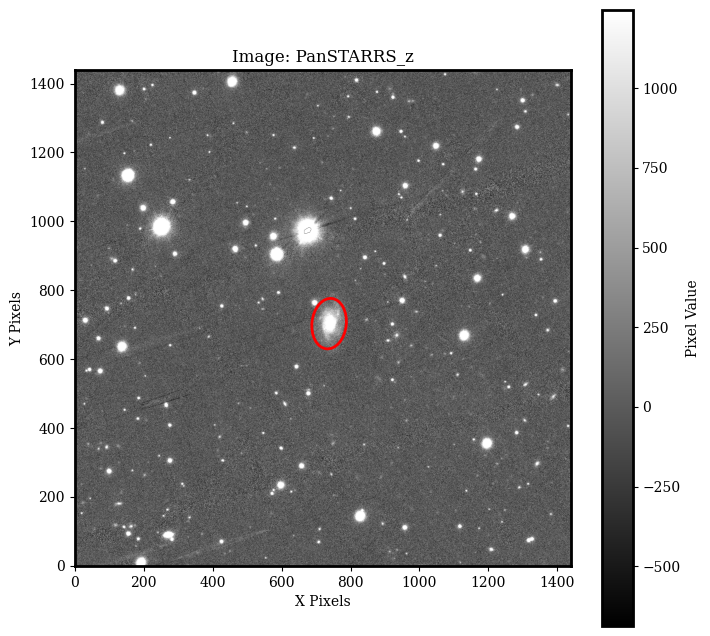

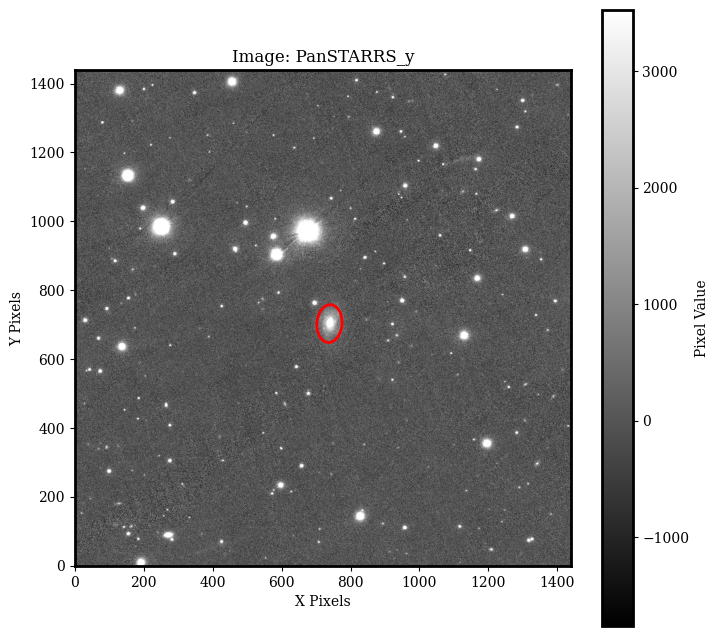

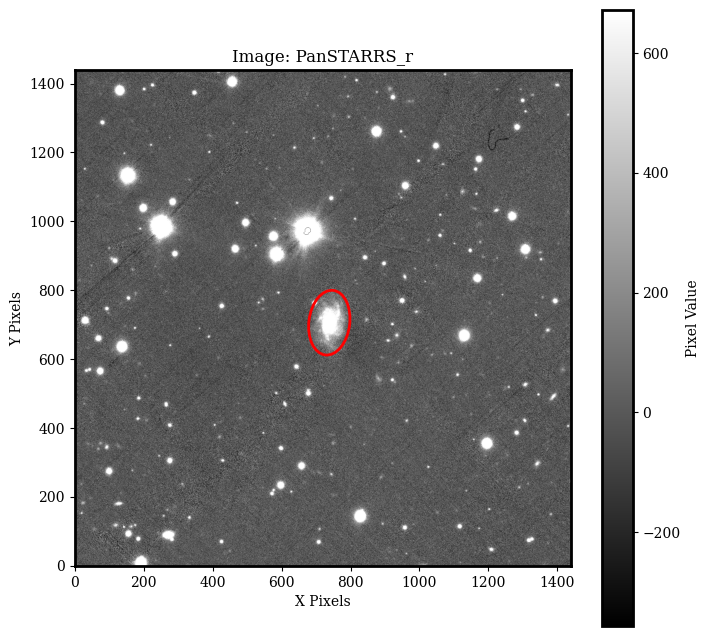

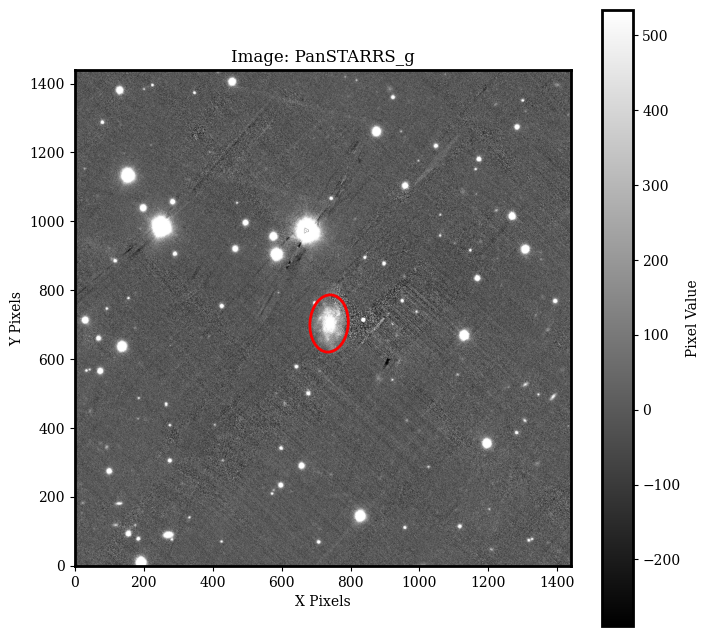

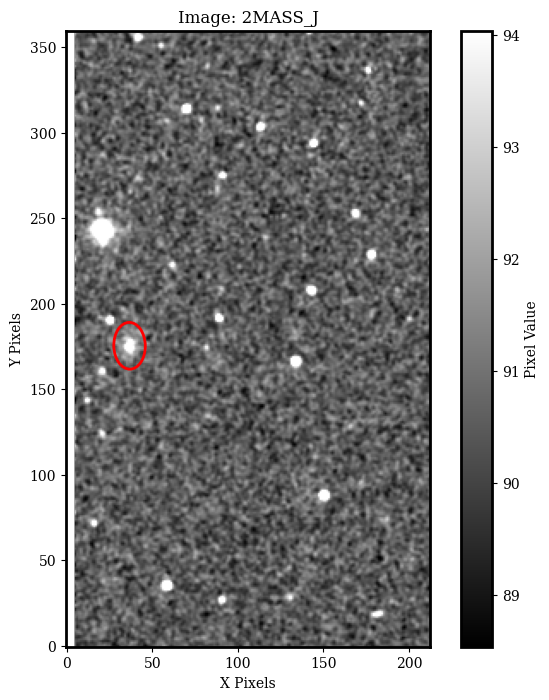

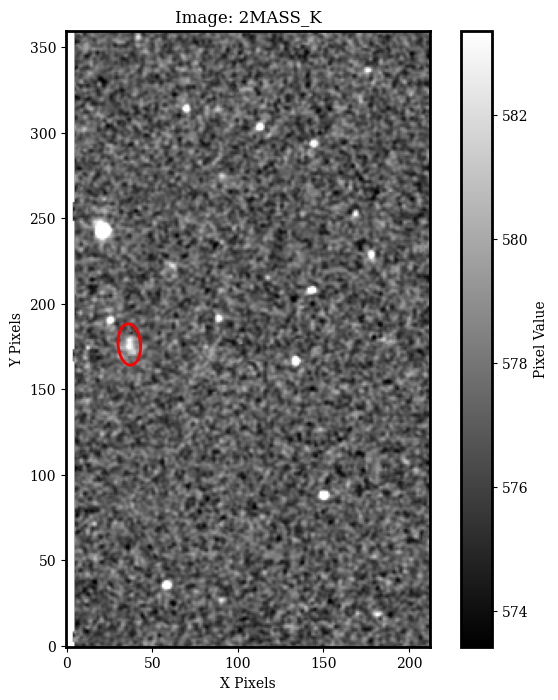

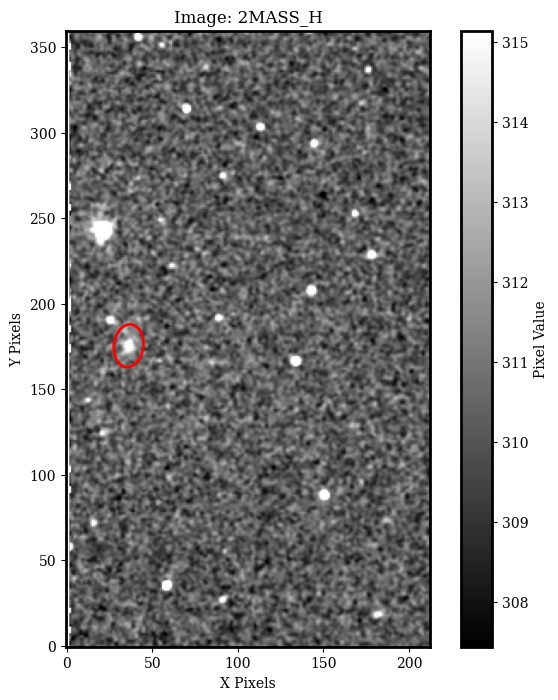

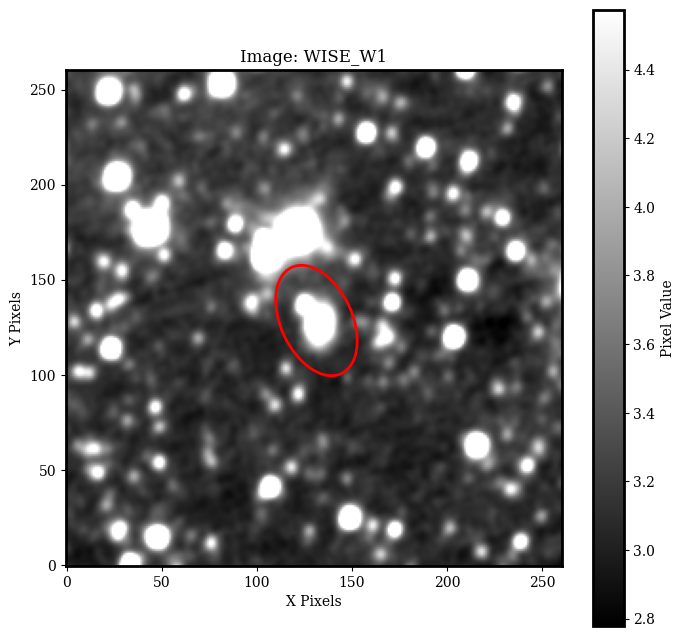

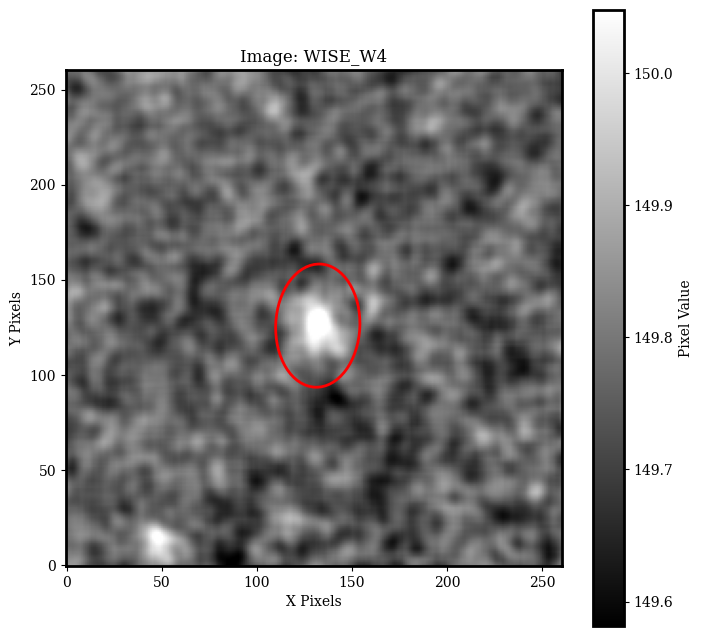

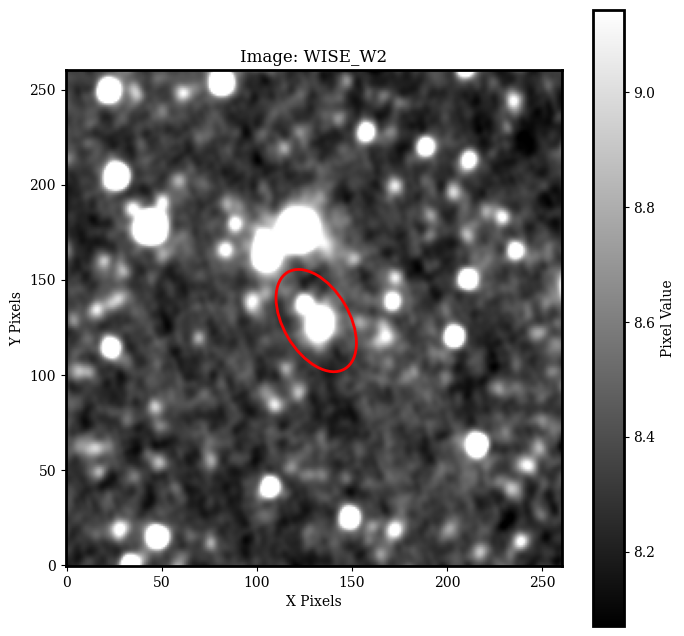

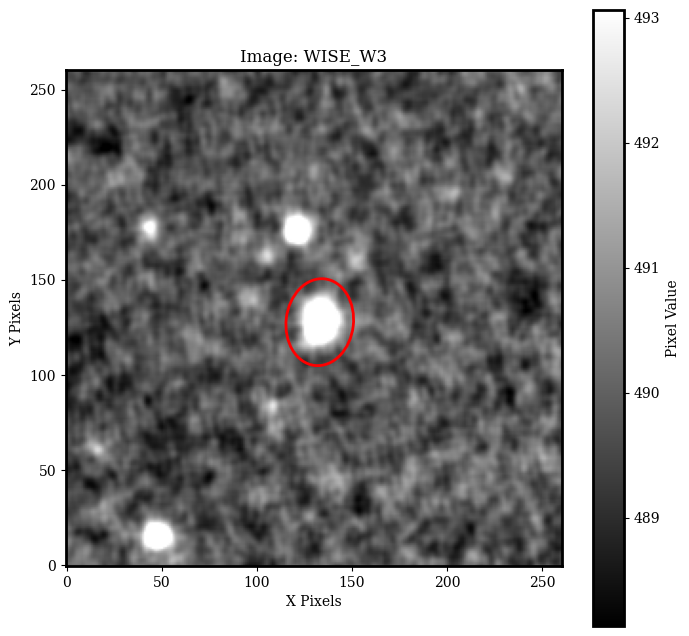

In [9]:
cutouts = transient_class.cutouts
global_apertures = []

for cutout in cutouts:
    print(cutout['filter'].name)
    aperture = construct_aperture(cutout, transient_class.host.coordinates)
    global_apertures.append(aperture)

transient_class.global_apertures = global_apertures



all_phot = []
for i in np.arange(0, len(cutouts),1):
    filt = cutouts[i]['filter']
    apr = transient_class.global_apertures[i] 
    phot = do_global_photometry(transient_class, filter=filt, aperture=apr, 
                fwhm_correction=False, show_plot=True)
    all_phot.append(phot)


transient_class.host_photometry = all_phot

Put the photometry and apertures in a dictionary - this will be used in the SED fit. We note that this photometry has not been extinction corrected and the magnitudes may be in differing units (e.g., Vega and AB) - the fluxes are ok to compare across surveys. This is all corrected in the SBI++ fit (and the SBI++ output file includes the extinction-corrected photometry in the same units), but please be aware of this if you are trying to use the photometry at this stage.

In [10]:
phot_dictionary = {'names': transient_class.name,
                   'phot': transient_class.host_photometry,
                   'apertures': transient_class.global_apertures,
                   'filternames': [cutout['filter'].name for cutout in cutouts]
                  }

# SED Fitting with SBI++

We use SBI++ to perform an SED fit to the host and constrain its stellar population properties. SBI++ is machine-learning mechanism and uses a trained model to estimate posterior density distributions on each property. The trained model and all other files associated with SBI++ are in ./data/SBI, ./data/sbipp_phot, and ./data/sbi_training_sets. We begin by setting grabbing paths to these files.

In [11]:
# Get roots
SBIPP_ROOT = os.environ.get("SBIPP_ROOT")
SBIPP_PHOT_ROOT = os.environ.get("SBIPP_PHOT_ROOT")
SBIPP_TRAINING_ROOT = os.environ.get("SBIPP_TRAINING_ROOT")
SED_OUTPUT_ROOT = os.environ.get("SED_OUTPUT_ROOT")

In this step, we determine if we want to run the spec-z SED fit or the photo-z SED fit. In the spec-z fit, we assume that the redshift of the host is the true redshift, and do not fit for redshift. In the photo-z fit, we assume that we do not have a redshift estimate on the host and determine our own posterior density distribution.

Here, we are using the transient redshift as the host's true redshift and pull all the models corresponding to the spec-z fit.

In [12]:
if best_host.redshift == None:
    # Set sbi params
    sbi_params = {
                "anpe_fname_global": f"{SBIPP_ROOT}/SBI_model_zfree_GPD2W_global.pt",  # trained sbi model
                "train_fname_global": f"{SBIPP_PHOT_ROOT}/sbi_phot_zfree_GPD2W_global.h5",  # training set
                "nhidden": 500,  # architecture of the trained density estimator
                "nblocks": 15,  # architecture of the trained density estimator
            }
    
    train_fname = 'zfree_GPD2W'
else:
    # Set sbi params
    sbi_params = {
                "anpe_fname_global": f"{SBIPP_ROOT}/SBI_model_zfix_GPD2W_global.pt",  # trained sbi model
                "train_fname_global": f"{SBIPP_PHOT_ROOT}/sbi_phot_zfix_GPD2W_global.h5",  # training set
                "nhidden": 500,  # architecture of the trained density estimator
                "nblocks": 15,  # architecture of the trained density estimator
            }
    
    train_fname = 'zfix_GPD2W'

print(train_fname)

zfix_GPD2W


We next clean our photometry to make sure we are not including any bad photometry (unconstrained upper limits may have negative fluxes) and match the filters used for photometry to those in the survey metadata file.

In [13]:
phot_filters = np.array(phot_dictionary['filternames'])

# Set filter objects to transient class
available_filters = []
update_phot = []
for filternames in phot_filters:
    filter_obj = next((f for f in filters if f.name == filternames), None)
    if filter_obj:
        phot_flux = np.array(phot_dictionary['phot'])[np.where(phot_filters == filternames)][0]['flux']
        phot_err = np.array(phot_dictionary['phot'])[np.where(phot_filters == filternames)][0]['flux_error']
        # Make sure no bad photometry is in here
        if phot_flux is not None:
            if phot_flux > 0:
                available_filters.append({"filter": filter_obj})
                update_phot.append(np.array(phot_dictionary['phot'])[np.where(phot_filters == filternames)][0])
        

transient_class.host_phot_filters = np.array(available_filters)
transient_class.host_photometry = np.array(update_phot)

We next run SBI++. This will run 50 mc samples and output two files in ./data/sed_output/transient_class.name/: and .h5 file which has the raw chains from the fit and an .npy file that has all the stellar population properties, converted to commonly used units (e.g., mass formed -> stellar mass, SFR and stellar population age are calculated, etc.). We also include model spectra and photometry and the observed photometry of the host. The npy file takes ~2 min to generate.

In general, we expect that SBI++ should take <15 min to run. If it is taking longer (or you do not see print out statements for the mc sampler), the fit has likely failed. This is probably due to the host being very faint (and therefore photometry is difficult to trust) or the host having very sparse and noisy photometry.

In [14]:
# Run SBI
start = time.time()

flag=fit_host(transient_class, sbi_params=sbi_params, fname=train_fname, all_filters = filters, mode='test', sbipp=True, 
            aperture_type='global', aperture=transient_class.global_apertures, save=True)


end = time.time()
length = end - start

print("It took", length/60, "minutes to run SBIPP!")
print('Host SED fit completed.')

Loaded observations and model
starting model fit
Loading training sets from data files...
Training sets loaded.
Host has spectroscopic redshift.
baseline sbi
/Users/anyanugent/Desktop/frankenblast-host-main/data/sed_output/2019ulo/2019ulo_global.h5


/opt/anaconda3/envs/frankenblast-hosts/lib/python3.10/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/opt/anaconda3/envs/frankenblast-hosts/lib/python3.10/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),


Saved to h5 file
Found best fit model SED.
Host model and stellar population properties saved to /Users/anyanugent/Desktop/frankenblast-host-main/data/sed_output/2019ulo/2019ulo_global.npy.
It took 2.347884547710419 minutes to run SBIPP!
Host SED fit completed.


# Post-Processing: Exploring the FrankenBlast SBI++ Output

Here, we show you how to analyze the SED fit output.

In [15]:
base_dir = "./data/sed_output/"  # Define base directory for input/output
transient_name = transient_class.name
model_dict = np.load(os.path.join(base_dir, transient_name, f"{transient_name}_global.npy"), allow_pickle=True).item(0)

Pull the observed photometry and the model spectra (16th, 50th, and 84th percentiles) and photometry and convert everything to mu-Jy.

In [16]:
flux_obs = np.array(model_dict['obs_phot']) * 3631e6  # mu-Jy
flux_obs_unc = np.array(model_dict['obs_phot_unc']) * 3631e6  #mu-Jy

# If we used a redshift in the fit, use this redshift
if model_dict['obs_redshift'] != None:
    zred = model_dict['obs_redshift']
# If we sampled redshift, pull the median redshift
else:
    zred = model_dict['mod_zred']
observed_wavelength = np.array(model_dict['rest_spec_wavelengths']) * (1+zred)

phot_wave = np.array(model_dict['phot_wave'])

best_spec = np.array(model_dict['best_spec']) * 3631e6
spec_16 = np.array(model_dict['spec_16']) * 3631e6
spec_84 = np.array(model_dict['spec_84']) * 3631e6
best_phot = np.array(model_dict['best_phot']) * 3631e6

Generate the SED

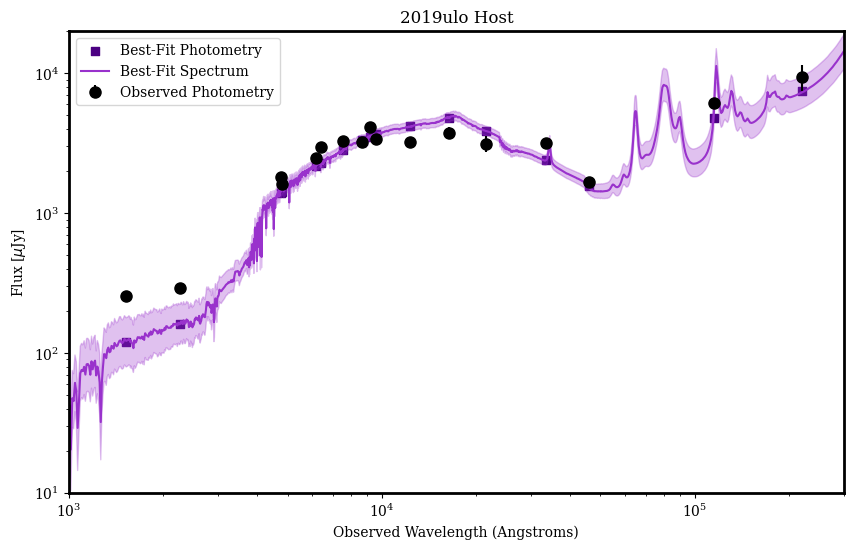

In [20]:
# Set the x-axis to logarithmic scale and label it in Angstroms
# Convert maggies to flux for plotting
plt.figure(figsize=(10, 6))

# Plot observed data points with error bars using rest_wavelength in Angstroms
plt.errorbar(
    phot_wave,  
    flux_obs,
    yerr=flux_obs_unc,
    fmt="o",
    ms = 8,
    color="black",
    label="Observed Photometry",
)



plt.scatter(phot_wave, best_phot, color="indigo", marker = 's', label="Best-Fit Photometry")

# Plot best-fit spectrum if available
plt.plot(observed_wavelength,best_spec,
        color="darkorchid",
        label="Best-Fit Spectrum",
        linestyle="-")


# Plot best-fit spectrum if available
plt.fill_between(observed_wavelength,spec_16,spec_84,
        color="darkorchid",
        linestyle="-", alpha=0.3)


plt.xscale("log")
plt.yscale("log")
plt.xlabel("Observed Wavelength (Angstroms)")
plt.ylabel("Flux [$\mu$Jy]")
plt.title(f"{transient_name} Host")
plt.xlim(1e3,3e5)
plt.ylim(1e1,2e4)
plt.legend(loc='upper left')

plt.show()

Now, we will make a corner plot to visualize the posteriors on the stellar population properties.

In [21]:
def theta_corner(model_dict, **kwargs):
    
    # Get parameter names 
    zred = model_dict['zred_chain']
    logzsol = model_dict['logzsol_chain'] 
    agntau = model_dict['log_agn_tau_chain']
    logmass = model_dict['stellar_mass_chain']
    age = model_dict['MWA_chain']
    SFR = model_dict['SFR_100_Myr_chain']
    fagn = model_dict['log_fagn_chain']
    dust = model_dict['dust_AV_chain']

    # If we did a spec-z fit
    if model_dict['obs_redshift'] is not None:
        new_theta = []
        for i in np.arange(0, len(logmass), 1):
            new_idx = [logmass[i], logzsol[i], age[i], dust[i], SFR[i], agntau[i], fagn[i]]
            new_theta.append(new_idx)
        new_theta = np.array(new_theta)
        param_latex = ['log($M_*/M_\odot$)', 'log($Z_*/Z_\odot$)', '$t_m$ [Gyr]', '$A_V$ [mag]', 'SFR', r'$\tau_{AGN}$', '$f_{AGN}$']

    # If we did a photo-z fit
    else:
        new_theta = []
        for i in np.arange(0, len(logmass), 1):
            new_idx = [zred[i], logmass[i], logzsol[i], age[i], dust[i], SFR[i], agntau[i], fagn[i]]
            new_theta.append(new_idx)
        new_theta = np.array(new_theta)
        param_latex = ['z','log($M_*/M_\odot$)', 'log($Z_*/Z_\odot$)', '$t_m$ [Gyr]', '$A_V$ [mag]', 'SFR', r'$\tau_{AGN}$', '$f_{AGN}$']
    
    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(np.array(new_theta), weights=None, nsample=100000)

    # plot figure
    figure = triangle.corner(theta_samp, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkorchid', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    return figure

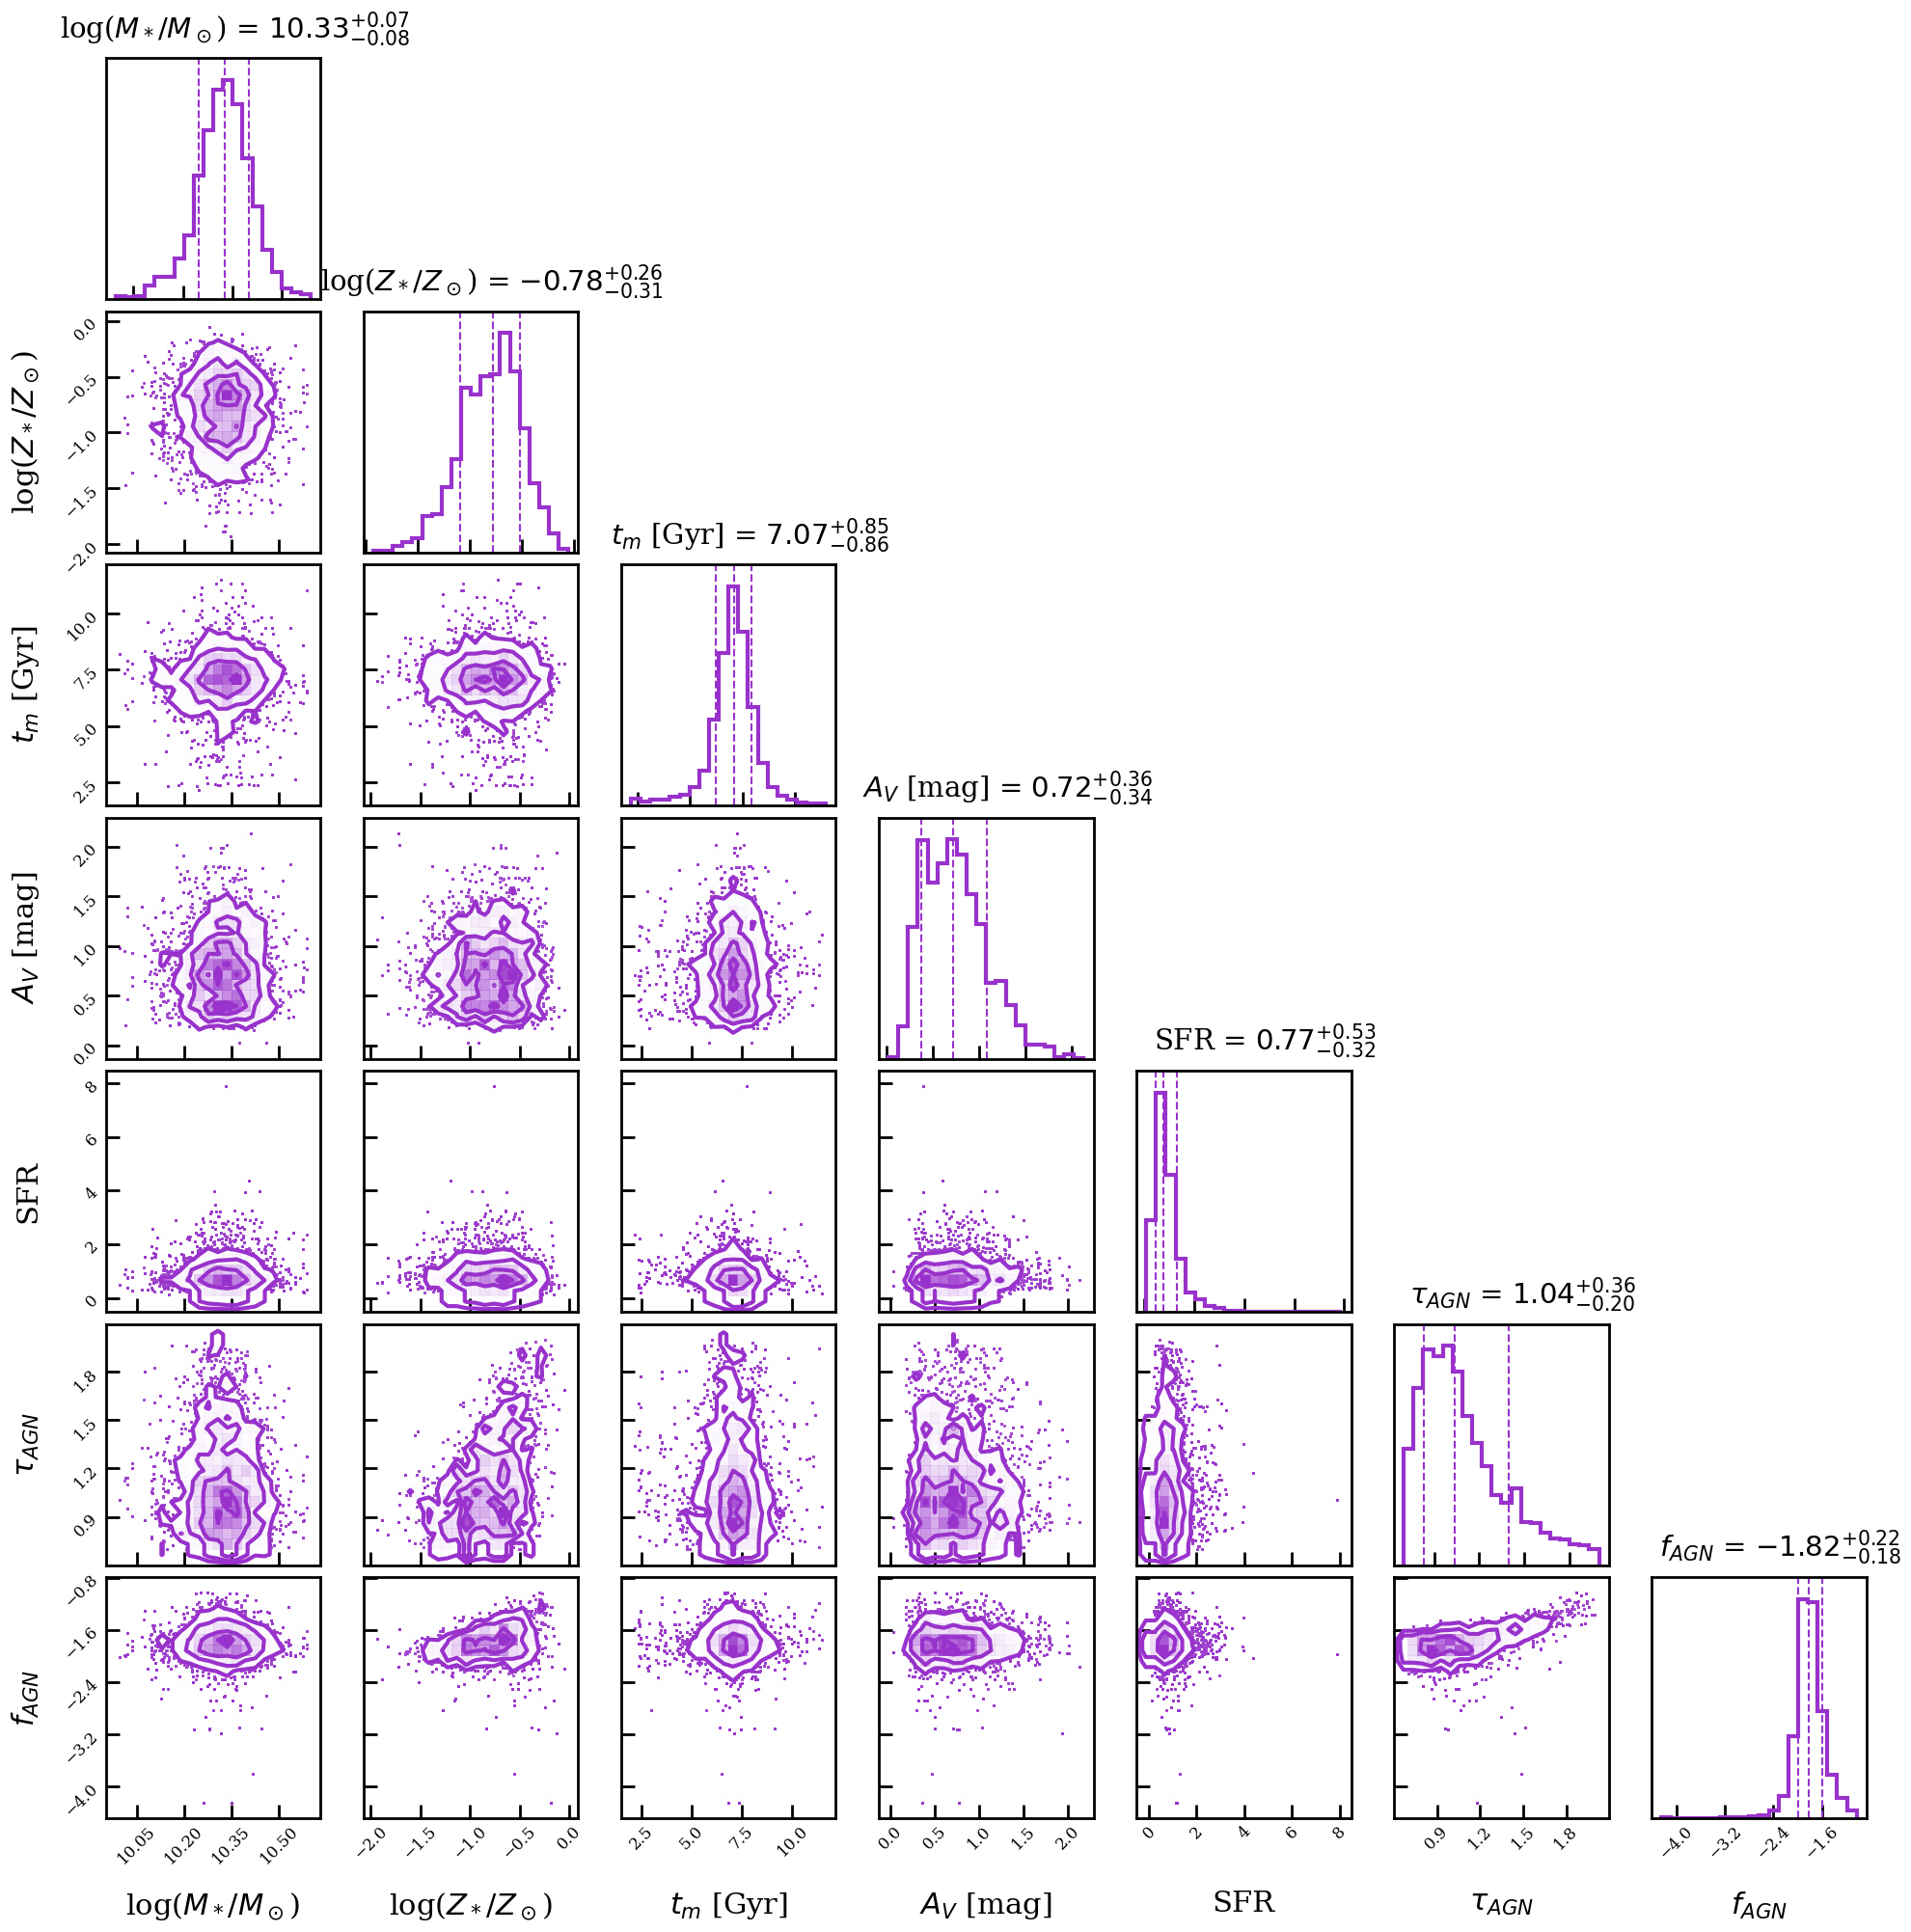

In [22]:
if model_dict['obs_redshift'] is not None:
    plot_dim = 7
else:
    plot_dim = 8

cornerfig = theta_corner(model_dict, fig=plt.subplots(plot_dim,plot_dim,figsize=(20,20))[0], 
                                      title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                                      label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
    
for ax in cornerfig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=10, width=2, direction='in')
    
plt.subplots_adjust(wspace=0.20, hspace=0.05)
plt.show()

We modeled the star formation history (SFH) of the host in the SBI++ SED fit with a 7-bin non-parametric model (see Nugent et al. 2025 for more details). We plot the SFH below.

<Figure size 1000x1000 with 0 Axes>

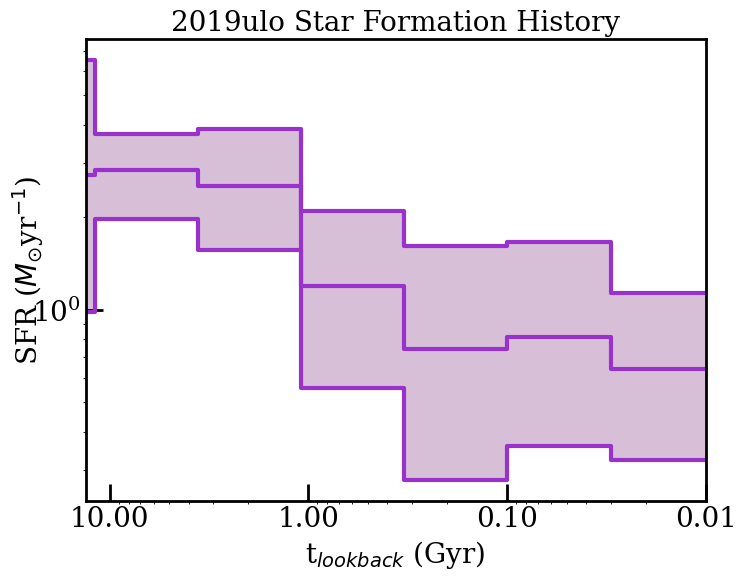

In [23]:
fig = plt.figure(figsize=[10,10])

fig, ax = plt.subplots(figsize=[8,6])
plt.title(f'{transient_name} Star Formation History', fontsize = 20)
plt.xlabel('t$_{lookback}$ (Gyr)', fontsize = 20)
plt.ylabel('SFR ($M_{\odot}$yr$^{-1}$)', fontsize = 20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.width'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 3
ax.tick_params(axis='x', which='minor')

t_lookback = model_dict['t_lookback_for_SFH']
SFH_lower = model_dict['SFH_lower']
SFH_upper = model_dict['SFH_upper']
SFH = model_dict['SFH_median']

# use step function to generate the SFH plot
plt.step(t_lookback, SFH_lower, alpha = 1, c = 'darkorchid', linewidth=3)
plt.step(t_lookback, SFH_upper, alpha = 1, c = 'darkorchid', linewidth=3)
plt.step(t_lookback, SFH, alpha = 1.0, c = 'darkorchid', linewidth=3)

# Since it's the lookback time, we want the x-axis limits to be flipped
plt.xlim(t_lookback[-1], 0.01) # setting max for aesthetic purposes
#plt.xscale('log')
plt.yscale('log')



for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=12, width=2, direction='in')
    ax.set_xscale('log')
    ax.set_xticks([0.01, 0.1, 1, 10])
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    #ax.xaxis.set_minor_formatter(mticker.ScalarFormatter(False))
    
    
    ax.yaxis.labelpad = -10

# shading the regions between 16th and 84th percentiles
plt.fill_between(t_lookback,SFH_lower,SFH_upper, where=None,interpolate=False,step='pre',color="thistle")

plt.show()